In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(50)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
epochs = 10
batch_size = 32
sequence_length = 96

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/netifier-2/netifier/processed_train.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/netifier-2/netifier/processed_test.csv', encoding='latin-1')

data = pd.concat([train_data, val_data], ignore_index=True)
data.shape

(7773, 7)

In [7]:
data.head()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik,processed_text
0,[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e...,kaskus,0,0,0,1,jabar memang provinsi barokah boleh juga dan n...
1,"@verosvante kita2 aja nitizen yang pada kepo,t...",instagram,0,0,0,0,kita saja nitizen yang pada penasaran toh kelu...
2,"""#SidangAhok smg sipenista agama n ateknya mat...",twitter,0,1,1,1,sidangahok semoga sipenista agama dan ateknya ...
3,@bolususulembang.jkt barusan baca undang2 ini....,instagram,0,0,0,0,jakarta barusan baca undang ini tetap dibedaka...
4,bikin anak mulu lu nof \nkaga mikir apa kasian...,kaskus,0,0,0,0,buat anak melulu kamu nof nkaga mikir apa kasi...


In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

train_labels = train_data.columns[2:6]
val_labels = val_data.columns[2:6]

# Extract features and labels for training and validation
X_train = train_data['processed_text'].values
y_train = train_data[train_labels].values
X_val = val_data['processed_text'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(6218,) (6218, 4)
(1555,) (1555, 4)


# BULDING DATASET

In [9]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

# Define custom Dataset class
class NetifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=96):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [10]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = NetifierDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = NetifierDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

In [11]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [12]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
        zero_division=0
    ) 

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [13]:
def train_model(current_train_size, train_indices, metrics, trials, seed, filename):
    accelerator = Accelerator(mixed_precision='fp16')
    device = accelerator.device
    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")

            nearest_cp = current_train_size
            if nearest_cp not in checkpoints:
                for cp in checkpoints:
                    if cp > current_train_size:
                        nearest_cp = cp
                        break
            percentage = math.ceil(nearest_cp / total_data * 100)
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"\n Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

In [14]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [15]:
def combined_sampling(model, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, filename):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    model.to(device)
    
    current_train_size = len(train_indices)
    
    # Check nearest checkpoint
    nearest_cp = 0
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    target_samples = math.ceil(0.1*len(remaining_indices))
    if target_samples <= min_increment and min_increment < nearest_cp - current_train_size:
        target_samples = min_increment
    elif target_samples > min_increment and target_samples < nearest_cp - current_train_size:
        target_samples = target_samples
    else:
        target_samples = nearest_cp - current_train_size

    accelerator.print(current_train_size, checkpoints[-1] - target_samples)
    final_cp = False
    # No sampling needed when there's little data left or we've reached the last checkpoint
    
    if current_train_size >= checkpoints[-1] - target_samples:
        final_cp = True

        if accelerator.is_main_process:
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'pornografi': [y_train[i][0] for i in temp],
                'sara': [y_train[i][1] for i in temp],
                'radikalisme': [y_train[i][2] for i in temp],
                'pencemaran_nama_baik': [y_train[i][3] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            
            sampling_dur.append(0)
            for i in remaining_indices:
                new_samples.append(i)

    accelerator.wait_for_everyone()
    if not final_cp:
        # Create dataset and dataloader for both methods
        dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
        dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=4,
            pin_memory=True,
        )
        
        # Start timing
        start_time = time.time()
        
        # Get KMeans samples
        kmeans_indices = get_kmeans_samples(model, dataloader, device, target_samples)
        kmeans_indices = [remaining_indices[i] for i in kmeans_indices]
        accelerator.print(f"Got {len(kmeans_indices)} samples from kmeans")
        
        # Get Least Confidence samples
        lc_indices = get_least_confidence_samples(model, dataloader, device, target_samples)
        lc_indices = [remaining_indices[i] for i in lc_indices]
        accelerator.print(f"Got {len(lc_indices)} samples from lc")
    
        if accelerator.is_main_process:
            # Combine both methods' results
            combined_indices = list(set(kmeans_indices).union(set(lc_indices)))
            
            # If we got more than we need, take only what we need
            if len(combined_indices) > target_samples:
                np.random.shuffle(combined_indices)
                combined_indices = combined_indices[:target_samples]
            
            # Calculate duration
            end_time = time.time()
            duration = end_time - start_time
            
            # Check if we've reached a checkpoint
            if current_train_size + len(combined_indices) >= nearest_cp:
                temp = train_indices.copy()
                temp.extend(combined_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'pornografi': [y_train[i][0] for i in temp],
                    'sara': [y_train[i][1] for i in temp],
                    'radikalisme': [y_train[i][2] for i in temp],
                    'pencemaran_nama_baik': [y_train[i][3] for i in temp],
                })
                acquired_data.to_csv(f'acquired_data/{filename}-data-{nearest_cp}.csv', index=False)
            
            # Log results
            print("Nearest checkpoint:", nearest_cp)
            print(f"Acquired samples: {len(combined_indices)}")
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in combined_indices:
                new_samples.append(i)

def get_kmeans_samples(model, dataloader, device, n_samples, n_clusters=min_increment):
    model.eval()
    embeddings = []
    
    # Get embeddings
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    # Convert embeddings list to numpy array
    embeddings = np.vstack(embeddings)
    
    # Cluster the data based on its embeddings
    kmeans = KMeans(n_clusters=n_clusters, n_init=1)
    kmeans.fit(embeddings)
    
    collected_indices = set()  # Initialize set to store selected indices
    
    for cluster_id in range(n_clusters):
        # Cluster center and indices of samples in the current cluster
        cluster_center = kmeans.cluster_centers_[cluster_id]
        cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
        
        if cluster_indices.size == 0:
            # Skip clusters with no members
            continue
        
        # Calculate distances of each point in the cluster from the cluster center
        cluster_distances = np.linalg.norm(embeddings[cluster_indices] - cluster_center, axis=1)
        
        # Determine the local threshold (90th percentile of distances to cluster center)
        local_threshold = np.percentile(cluster_distances, 90)
        
        # Get indices of points with distances greater than or equal to threshold
        below_threshold_indices = cluster_indices[cluster_distances >= local_threshold]
        collected_indices.update(below_threshold_indices)
    
    # Randomly shuffle and select required number of samples
    collected_indices = np.array(list(collected_indices))
    
    # Return only the requested number of samples
    return collected_indices[:n_samples]

def get_least_confidence_samples(model, dataloader, device, n_samples):
    model.eval()
    uncertainties = []
    
    # Calculate uncertainties
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
        
        for output in outputs:
            probs = torch.sigmoid(output).cpu().numpy()
            uncertainty = np.absolute(1 - np.max(probs))
            uncertainties.append(uncertainty)
    
    uncertainties = np.array(uncertainties)
    sorted_unc = np.argsort(uncertainties)
    sorted_unc = sorted_unc[::-1]  # Reverse to get highest uncertainty first

    threshold = np.percentile(uncertainties, 90)
    items_greater_than_average = uncertainties[uncertainties >= threshold]
    least_confident_indices = sorted_unc[:n_samples]

    return least_confident_indices

In [16]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    filename = 'netifier-lc-kmeans'

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed, filename)
        notebook_launcher(train_model, args, num_processes=2)

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-model-{percentage}')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i, filename)
        notebook_launcher(combined_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed, filename)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-results.csv', index=False)

In [17]:
seeds = [50, 81, 14, 3, 94]

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5903, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4917, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4703, Accuracy: 0.8167, F1 Micro: 0.259, F1 Macro: 0.187
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.398, Accuracy: 0.8417, F1 Micro: 0.4813, F1 Macro: 0.414
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3739, Accuracy: 0.8522, F1 Micro: 0.5456, F1 Macro: 0.4863
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3021, Accuracy: 0.8609, F1 Micro: 0.6048, F1 Macro: 0.5756
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2618, Accuracy: 0.867, F1 Micro: 0.678, F1 Macro: 0.6657
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2249, Accuracy: 0.8678, F1 Micro: 0.68, F1 Macro: 0.6722
Epoch 9/10, Train Loss: 0.1872, Accuracy: 0.8722, F1 Micro: 0.6715, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4957, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3576, Accuracy: 0.8259, F1 Micro: 0.3248, F1 Macro: 0.2277
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2948, Accuracy: 0.8581, F1 Micro: 0.5796, F1 Macro: 0.5177
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2407, Accuracy: 0.8731, F1 Micro: 0.6862, F1 Macro: 0.6695
Epoch 5/10, Train Loss: 0.1916, Accuracy: 0.8775, F1 Micro: 0.6689, F1 Macro: 0.6496
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.163, Accuracy: 0.8825, F1 Micro: 0.7006, F1 Macro: 0.6845
Epoch 7/10, Train Loss: 0.127, Accuracy: 0.8802, F1 Micro: 0.6977, F1 Macro: 0.6887
Epoch 8/10, Train Loss: 0.0903, Accuracy: 0.8797, F1 Micro: 0.6823, F1 Macro: 0.6674
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0825, Accuracy: 0.8797, F1 Micro: 0.7222, F1 Macro: 0.7181
Epoch 10/10, Train Loss: 0.0587, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4439, Accuracy: 0.8098, F1 Micro: 0.1978, F1 Macro: 0.1511
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3014, Accuracy: 0.8644, F1 Micro: 0.6313, F1 Macro: 0.5809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2332, Accuracy: 0.8684, F1 Micro: 0.7109, F1 Macro: 0.7036
Epoch 4/10, Train Loss: 0.1831, Accuracy: 0.8809, F1 Micro: 0.6885, F1 Macro: 0.6802
Epoch 5/10, Train Loss: 0.1522, Accuracy: 0.8864, F1 Micro: 0.7058, F1 Macro: 0.7006
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1205, Accuracy: 0.8789, F1 Micro: 0.7423, F1 Macro: 0.7414
Epoch 7/10, Train Loss: 0.0953, Accuracy: 0.8922, F1 Micro: 0.7352, F1 Macro: 0.7309
Epoch 8/10, Train Loss: 0.0676, Accuracy: 0.8905, F1 Micro: 0.741, F1 Macro: 0.7381
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0472, Accuracy: 0.8892, F1 Micro: 0.7432, F1 Macro: 0.741
Epoch 10/10, Train Loss: 0.0419, Accuracy: 0.8906, F1 Micro: 0.7366, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.426, Accuracy: 0.8242, F1 Micro: 0.3043, F1 Macro: 0.2145
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2745, Accuracy: 0.8606, F1 Micro: 0.5678, F1 Macro: 0.5375
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2175, Accuracy: 0.8803, F1 Micro: 0.6886, F1 Macro: 0.6851
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1633, Accuracy: 0.8909, F1 Micro: 0.7346, F1 Macro: 0.7264
Epoch 5/10, Train Loss: 0.1253, Accuracy: 0.8883, F1 Micro: 0.7177, F1 Macro: 0.7067
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1091, Accuracy: 0.8923, F1 Micro: 0.7351, F1 Macro: 0.7269
Epoch 7/10, Train Loss: 0.0735, Accuracy: 0.8936, F1 Micro: 0.7307, F1 Macro: 0.7253
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0574, Accuracy: 0.8964, F1 Micro: 0.7599, F1 Macro: 0.7604
Epoch 9/10, Train Loss: 0.0454, Accuracy: 0.8909, F1 Micro: 0.7324, F1 Macro: 0.7318
Epoch 10/10, Train Loss: 0.0362, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3872, Accuracy: 0.832, F1 Micro: 0.3889, F1 Macro: 0.2657
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2501, Accuracy: 0.8745, F1 Micro: 0.6913, F1 Macro: 0.6835
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1832, Accuracy: 0.8844, F1 Micro: 0.7052, F1 Macro: 0.7007
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1449, Accuracy: 0.8897, F1 Micro: 0.7381, F1 Macro: 0.7307
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1235, Accuracy: 0.8939, F1 Micro: 0.7419, F1 Macro: 0.7409
Epoch 6/10, Train Loss: 0.084, Accuracy: 0.8934, F1 Micro: 0.7393, F1 Macro: 0.7308
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0694, Accuracy: 0.8911, F1 Micro: 0.7555, F1 Macro: 0.7533
Epoch 8/10, Train Loss: 0.053, Accuracy: 0.8847, F1 Micro: 0.7547, F1 Macro: 0.7593
Epoch 9/10, Train Loss: 0.0383, Accuracy: 0.8872, F1 Micro: 0.7554, F1 Macro: 0.7578
Epoch 10/10, Train Loss: 0.0338, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3973, Accuracy: 0.8455, F1 Micro: 0.4878, F1 Macro: 0.3615
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2427, Accuracy: 0.8756, F1 Micro: 0.65, F1 Macro: 0.6427
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1887, Accuracy: 0.8895, F1 Micro: 0.7339, F1 Macro: 0.7149
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1432, Accuracy: 0.8934, F1 Micro: 0.7482, F1 Macro: 0.7455
Epoch 5/10, Train Loss: 0.1069, Accuracy: 0.8939, F1 Micro: 0.7458, F1 Macro: 0.7391
Epoch 6/10, Train Loss: 0.0768, Accuracy: 0.8931, F1 Micro: 0.7455, F1 Macro: 0.744
Epoch 7/10, Train Loss: 0.0619, Accuracy: 0.8934, F1 Micro: 0.7294, F1 Macro: 0.7161
Epoch 8/10, Train Loss: 0.0517, Accuracy: 0.8922, F1 Micro: 0.7358, F1 Macro: 0.7226
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0353, Accuracy: 0.8925, F1 Micro: 0.7534, F1 Macro: 0.7524
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0263, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3866, Accuracy: 0.8409, F1 Micro: 0.4376, F1 Macro: 0.3609
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2375, Accuracy: 0.8856, F1 Micro: 0.7252, F1 Macro: 0.7181
Epoch 3/10, Train Loss: 0.1885, Accuracy: 0.8877, F1 Micro: 0.6908, F1 Macro: 0.6706
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1449, Accuracy: 0.8967, F1 Micro: 0.7423, F1 Macro: 0.7357
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1191, Accuracy: 0.8919, F1 Micro: 0.7596, F1 Macro: 0.7584
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0802, Accuracy: 0.8969, F1 Micro: 0.7691, F1 Macro: 0.7685
Epoch 7/10, Train Loss: 0.0679, Accuracy: 0.9003, F1 Micro: 0.7585, F1 Macro: 0.7544
Epoch 8/10, Train Loss: 0.0446, Accuracy: 0.8966, F1 Micro: 0.7594, F1 Macro: 0.7574
Epoch 9/10, Train Loss: 0.0355, Accuracy: 0.8975, F1 Micro: 0.7602, F1 Macro: 0.7594
Epoch 10/10, Train Loss: 0.0299, Accuracy: 0.8919, F1 Micro: 0.7548, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3802, Accuracy: 0.8542, F1 Micro: 0.529, F1 Macro: 0.4536
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2395, Accuracy: 0.8825, F1 Micro: 0.69, F1 Macro: 0.6786
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1947, Accuracy: 0.8967, F1 Micro: 0.7567, F1 Macro: 0.7565
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.157, Accuracy: 0.9003, F1 Micro: 0.7668, F1 Macro: 0.7626
Epoch 5/10, Train Loss: 0.1191, Accuracy: 0.8941, F1 Micro: 0.7558, F1 Macro: 0.7468
Epoch 6/10, Train Loss: 0.0845, Accuracy: 0.8981, F1 Micro: 0.7626, F1 Macro: 0.7595
Epoch 7/10, Train Loss: 0.0631, Accuracy: 0.8978, F1 Micro: 0.7622, F1 Macro: 0.7604
Epoch 8/10, Train Loss: 0.0491, Accuracy: 0.8972, F1 Micro: 0.7584, F1 Macro: 0.7601
Epoch 9/10, Train Loss: 0.0389, Accuracy: 0.8975, F1 Micro: 0.7625, F1 Macro: 0.7587
Epoch 10/10, Train Loss: 0.0281, Accuracy: 0.8988, F1 Micro: 0.7611, F1 Macro: 0.754

 Iteration 3432: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3796, Accuracy: 0.8645, F1 Micro: 0.6186, F1 Macro: 0.5911
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2429, Accuracy: 0.8894, F1 Micro: 0.7304, F1 Macro: 0.7237
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1853, Accuracy: 0.9013, F1 Micro: 0.7615, F1 Macro: 0.7537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1476, Accuracy: 0.8911, F1 Micro: 0.7643, F1 Macro: 0.7637
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1124, Accuracy: 0.8975, F1 Micro: 0.7654, F1 Macro: 0.7574
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0875, Accuracy: 0.8981, F1 Micro: 0.772, F1 Macro: 0.7682
Epoch 7/10, Train Loss: 0.0626, Accuracy: 0.8969, F1 Micro: 0.7669, F1 Macro: 0.7642
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0475, Accuracy: 0.8963, F1 Micro: 0.7749, F1 Macro: 0.7754
Epoch 9/10, Train Loss: 0.0375, Accuracy: 0.9003, F1 Micro: 0.7666, F1 Macro: 0.7609
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.375, Accuracy: 0.8642, F1 Micro: 0.6077, F1 Macro: 0.5891
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2303, Accuracy: 0.8897, F1 Micro: 0.7125, F1 Macro: 0.7064
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1896, Accuracy: 0.8986, F1 Micro: 0.7528, F1 Macro: 0.7398
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1474, Accuracy: 0.8991, F1 Micro: 0.7582, F1 Macro: 0.7471
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1154, Accuracy: 0.8963, F1 Micro: 0.771, F1 Macro: 0.7713
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0855, Accuracy: 0.9011, F1 Micro: 0.778, F1 Macro: 0.7769
Epoch 7/10, Train Loss: 0.065, Accuracy: 0.8973, F1 Micro: 0.7663, F1 Macro: 0.762
Epoch 8/10, Train Loss: 0.0465, Accuracy: 0.8983, F1 Micro: 0.7657, F1 Macro: 0.757
Epoch 9/10, Train Loss: 0.0369, Accuracy: 0.8978, F1 Micro: 0.7737, F1 Macro: 0.7712
Epoch 10/10, Train Loss: 0.0282, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.376, Accuracy: 0.8709, F1 Micro: 0.6497, F1 Macro: 0.6378
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2305, Accuracy: 0.8911, F1 Micro: 0.7272, F1 Macro: 0.7213
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1867, Accuracy: 0.8983, F1 Micro: 0.7584, F1 Macro: 0.7522
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1514, Accuracy: 0.8867, F1 Micro: 0.7628, F1 Macro: 0.7642
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1068, Accuracy: 0.8981, F1 Micro: 0.7755, F1 Macro: 0.7742
Epoch 6/10, Train Loss: 0.0801, Accuracy: 0.9022, F1 Micro: 0.7709, F1 Macro: 0.7655
Epoch 7/10, Train Loss: 0.0642, Accuracy: 0.9033, F1 Micro: 0.7722, F1 Macro: 0.7692
Epoch 8/10, Train Loss: 0.0464, Accuracy: 0.8998, F1 Micro: 0.7672, F1 Macro: 0.7637
Epoch 9/10, Train Loss: 0.0353, Accuracy: 0.8994, F1 Micro: 0.7742, F1 Macro: 0.7715
Epoch 10/10, Train Loss: 0.0281, Accuracy: 0.897, F1 Micro: 0.775, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3838, Accuracy: 0.867, F1 Micro: 0.6302, F1 Macro: 0.614
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2388, Accuracy: 0.8867, F1 Micro: 0.7384, F1 Macro: 0.7386
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1958, Accuracy: 0.8969, F1 Micro: 0.7729, F1 Macro: 0.7708
Epoch 4/10, Train Loss: 0.1538, Accuracy: 0.8984, F1 Micro: 0.7596, F1 Macro: 0.7566
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1162, Accuracy: 0.8936, F1 Micro: 0.7743, F1 Macro: 0.7757
Epoch 6/10, Train Loss: 0.0873, Accuracy: 0.8998, F1 Micro: 0.7639, F1 Macro: 0.7613
Epoch 7/10, Train Loss: 0.0686, Accuracy: 0.8966, F1 Micro: 0.772, F1 Macro: 0.7695
Epoch 8/10, Train Loss: 0.0468, Accuracy: 0.8961, F1 Micro: 0.7706, F1 Macro: 0.7669
Epoch 9/10, Train Loss: 0.0358, Accuracy: 0.9006, F1 Micro: 0.7717, F1 Macro: 0.7688
Epoch 10/10, Train Loss: 0.0302, Accuracy: 0.8917, F1 Micro: 0.7674, F1 Macro: 0.7685

 Iteration 4330: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3827, Accuracy: 0.8706, F1 Micro: 0.6294, F1 Macro: 0.5911
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2495, Accuracy: 0.8923, F1 Micro: 0.7457, F1 Macro: 0.7323
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1935, Accuracy: 0.8994, F1 Micro: 0.7492, F1 Macro: 0.7483
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.159, Accuracy: 0.902, F1 Micro: 0.7709, F1 Macro: 0.7645
Epoch 5/10, Train Loss: 0.1153, Accuracy: 0.8998, F1 Micro: 0.7637, F1 Macro: 0.7587
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0888, Accuracy: 0.9019, F1 Micro: 0.7744, F1 Macro: 0.77
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0678, Accuracy: 0.8991, F1 Micro: 0.7746, F1 Macro: 0.7733
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0503, Accuracy: 0.9028, F1 Micro: 0.7766, F1 Macro: 0.7742
Epoch 9/10, Train Loss: 0.043, Accuracy: 0.8973, F1 Micro: 0.7612, F1 Macro: 0.7627
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3823, Accuracy: 0.8736, F1 Micro: 0.6667, F1 Macro: 0.6635
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2378, Accuracy: 0.8995, F1 Micro: 0.7614, F1 Macro: 0.7498
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1993, Accuracy: 0.9016, F1 Micro: 0.7774, F1 Macro: 0.771
Epoch 4/10, Train Loss: 0.1594, Accuracy: 0.9017, F1 Micro: 0.7687, F1 Macro: 0.762
Epoch 5/10, Train Loss: 0.1169, Accuracy: 0.902, F1 Micro: 0.7649, F1 Macro: 0.7597
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.088, Accuracy: 0.9006, F1 Micro: 0.7817, F1 Macro: 0.7831
Epoch 7/10, Train Loss: 0.0655, Accuracy: 0.8984, F1 Micro: 0.7768, F1 Macro: 0.7763
Epoch 8/10, Train Loss: 0.0506, Accuracy: 0.9028, F1 Micro: 0.7753, F1 Macro: 0.772
Epoch 9/10, Train Loss: 0.0393, Accuracy: 0.9013, F1 Micro: 0.7715, F1 Macro: 0.7701
Epoch 10/10, Train Loss: 0.0285, Accuracy: 0.9005, F1 Micro: 0.7781, F1 Macro: 0.7792

 Iteration 4663: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3897, Accuracy: 0.8733, F1 Micro: 0.6688, F1 Macro: 0.6681
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2496, Accuracy: 0.8923, F1 Micro: 0.7106, F1 Macro: 0.6887
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.204, Accuracy: 0.9014, F1 Micro: 0.7638, F1 Macro: 0.761
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1525, Accuracy: 0.9009, F1 Micro: 0.7815, F1 Macro: 0.7797
Epoch 5/10, Train Loss: 0.123, Accuracy: 0.9034, F1 Micro: 0.7762, F1 Macro: 0.7725
Epoch 6/10, Train Loss: 0.0873, Accuracy: 0.9008, F1 Micro: 0.7722, F1 Macro: 0.7666
Epoch 7/10, Train Loss: 0.062, Accuracy: 0.8961, F1 Micro: 0.7676, F1 Macro: 0.77
Epoch 8/10, Train Loss: 0.049, Accuracy: 0.9002, F1 Micro: 0.7767, F1 Macro: 0.7733
Epoch 9/10, Train Loss: 0.0356, Accuracy: 0.9006, F1 Micro: 0.7753, F1 Macro: 0.7742
Epoch 10/10, Train Loss: 0.0308, Accuracy: 0.8989, F1 Micro: 0.7705, F1 Macro: 0.769

 Iteration 4863: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3838, Accuracy: 0.8819, F1 Micro: 0.7132, F1 Macro: 0.7083
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2483, Accuracy: 0.8955, F1 Micro: 0.763, F1 Macro: 0.7585
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1993, Accuracy: 0.9014, F1 Micro: 0.7733, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1537, Accuracy: 0.9014, F1 Micro: 0.7847, F1 Macro: 0.784
Epoch 5/10, Train Loss: 0.1166, Accuracy: 0.9023, F1 Micro: 0.7665, F1 Macro: 0.7572
Epoch 6/10, Train Loss: 0.0879, Accuracy: 0.9041, F1 Micro: 0.7674, F1 Macro: 0.7636
Epoch 7/10, Train Loss: 0.0706, Accuracy: 0.9036, F1 Micro: 0.7688, F1 Macro: 0.7657
Epoch 8/10, Train Loss: 0.0519, Accuracy: 0.9016, F1 Micro: 0.7782, F1 Macro: 0.7734
Epoch 9/10, Train Loss: 0.0378, Accuracy: 0.9059, F1 Micro: 0.7806, F1 Macro: 0.7774
Epoch 10/10, Train Loss: 0.0318, Accuracy: 0.8997, F1 Micro: 0.7723, F1 Macro: 0.771

 Iteration 5063: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3771, Accuracy: 0.8822, F1 Micro: 0.7356, F1 Macro: 0.7315
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2505, Accuracy: 0.8983, F1 Micro: 0.7501, F1 Macro: 0.7391
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2016, Accuracy: 0.9003, F1 Micro: 0.754, F1 Macro: 0.7506
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1653, Accuracy: 0.9048, F1 Micro: 0.7703, F1 Macro: 0.7572
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.132, Accuracy: 0.9062, F1 Micro: 0.7771, F1 Macro: 0.7682
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.09, Accuracy: 0.9083, F1 Micro: 0.7832, F1 Macro: 0.7781
Epoch 7/10, Train Loss: 0.0643, Accuracy: 0.9016, F1 Micro: 0.7756, F1 Macro: 0.7732
Epoch 8/10, Train Loss: 0.0516, Accuracy: 0.9058, F1 Micro: 0.7784, F1 Macro: 0.7739
Epoch 9/10, Train Loss: 0.0429, Accuracy: 0.9017, F1 Micro: 0.7775, F1 Macro: 0.7757
Epoch 10/10, Train Loss: 0.0311, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3942, Accuracy: 0.8795, F1 Micro: 0.6721, F1 Macro: 0.6458
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2482, Accuracy: 0.8964, F1 Micro: 0.7484, F1 Macro: 0.7368
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2071, Accuracy: 0.8973, F1 Micro: 0.7781, F1 Macro: 0.7772
Epoch 4/10, Train Loss: 0.1728, Accuracy: 0.9017, F1 Micro: 0.774, F1 Macro: 0.7666
Epoch 5/10, Train Loss: 0.1299, Accuracy: 0.9053, F1 Micro: 0.7779, F1 Macro: 0.7722
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0978, Accuracy: 0.9002, F1 Micro: 0.7823, F1 Macro: 0.7821
Epoch 7/10, Train Loss: 0.0637, Accuracy: 0.9052, F1 Micro: 0.7763, F1 Macro: 0.7732
Epoch 8/10, Train Loss: 0.0517, Accuracy: 0.9011, F1 Micro: 0.7694, F1 Macro: 0.766
Epoch 9/10, Train Loss: 0.0392, Accuracy: 0.9056, F1 Micro: 0.7753, F1 Macro: 0.7728
Epoch 10/10, Train Loss: 0.0312, Accuracy: 0.9019, F1 Micro: 0.7819, F1 Macro: 0.7805

 Iteration 5441: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3801, Accuracy: 0.8847, F1 Micro: 0.695, F1 Macro: 0.6923
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2518, Accuracy: 0.8991, F1 Micro: 0.7531, F1 Macro: 0.7406
Epoch 3/10, Train Loss: 0.2021, Accuracy: 0.9022, F1 Micro: 0.7508, F1 Macro: 0.7485
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1626, Accuracy: 0.8997, F1 Micro: 0.778, F1 Macro: 0.7769
Epoch 5/10, Train Loss: 0.1224, Accuracy: 0.9016, F1 Micro: 0.768, F1 Macro: 0.7619
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0864, Accuracy: 0.9028, F1 Micro: 0.7791, F1 Macro: 0.7798
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0652, Accuracy: 0.905, F1 Micro: 0.783, F1 Macro: 0.7822
Epoch 8/10, Train Loss: 0.0476, Accuracy: 0.9034, F1 Micro: 0.7771, F1 Macro: 0.7737
Epoch 9/10, Train Loss: 0.0417, Accuracy: 0.9031, F1 Micro: 0.7744, F1 Macro: 0.7735
Epoch 10/10, Train Loss: 0.0338, Accuracy: 0.8953, F1 Micro: 0.7738, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3754, Accuracy: 0.8764, F1 Micro: 0.7426, F1 Macro: 0.7453
Epoch 2/10, Train Loss: 0.2456, Accuracy: 0.8963, F1 Micro: 0.7256, F1 Macro: 0.7164
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2022, Accuracy: 0.9016, F1 Micro: 0.7745, F1 Macro: 0.77
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1597, Accuracy: 0.9056, F1 Micro: 0.7758, F1 Macro: 0.7622
Epoch 5/10, Train Loss: 0.1276, Accuracy: 0.905, F1 Micro: 0.7728, F1 Macro: 0.7626
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.092, Accuracy: 0.905, F1 Micro: 0.7845, F1 Macro: 0.784
Epoch 7/10, Train Loss: 0.0654, Accuracy: 0.9048, F1 Micro: 0.7816, F1 Macro: 0.7811
Epoch 8/10, Train Loss: 0.0499, Accuracy: 0.9052, F1 Micro: 0.7772, F1 Macro: 0.7695
Epoch 9/10, Train Loss: 0.0362, Accuracy: 0.908, F1 Micro: 0.7827, F1 Macro: 0.7765
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0304, Accuracy: 0.9056, F1 Micro: 0.7867, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3784, Accuracy: 0.8875, F1 Micro: 0.7291, F1 Macro: 0.7244
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2445, Accuracy: 0.9005, F1 Micro: 0.7615, F1 Macro: 0.7543
Epoch 3/10, Train Loss: 0.2003, Accuracy: 0.902, F1 Micro: 0.7608, F1 Macro: 0.7523
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1606, Accuracy: 0.9066, F1 Micro: 0.7737, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.12, Accuracy: 0.9059, F1 Micro: 0.7749, F1 Macro: 0.7652
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.905, F1 Micro: 0.7844, F1 Macro: 0.7815
Epoch 7/10, Train Loss: 0.0676, Accuracy: 0.9055, F1 Micro: 0.7807, F1 Macro: 0.7778
Epoch 8/10, Train Loss: 0.0536, Accuracy: 0.9044, F1 Micro: 0.7696, F1 Macro: 0.7607
Epoch 9/10, Train Loss: 0.043, Accuracy: 0.9066, F1 Micro: 0.7765, F1 Macro: 0.7722
Epoch 10/10, Train Loss: 0.0338, Accuracy: 0.9033, F1 Micro: 0.7769, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3619, Accuracy: 0.8916, F1 Micro: 0.7467, F1 Macro: 0.7422
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2301, Accuracy: 0.8981, F1 Micro: 0.7675, F1 Macro: 0.7632
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1948, Accuracy: 0.9, F1 Micro: 0.7852, F1 Macro: 0.7834
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1529, Accuracy: 0.9034, F1 Micro: 0.7891, F1 Macro: 0.7867
Epoch 5/10, Train Loss: 0.1156, Accuracy: 0.9044, F1 Micro: 0.7781, F1 Macro: 0.775
Epoch 6/10, Train Loss: 0.0911, Accuracy: 0.903, F1 Micro: 0.7581, F1 Macro: 0.7475
Epoch 7/10, Train Loss: 0.0716, Accuracy: 0.9083, F1 Micro: 0.7824, F1 Macro: 0.7799
Epoch 8/10, Train Loss: 0.0502, Accuracy: 0.9059, F1 Micro: 0.7842, F1 Macro: 0.7797
Epoch 9/10, Train Loss: 0.0383, Accuracy: 0.9064, F1 Micro: 0.7786, F1 Macro: 0.7753
Epoch 10/10, Train Loss: 0.0328, Accuracy: 0.9053, F1 Micro: 0.7796, F1 Macro: 0.7753

 Iteration 6218: Accu

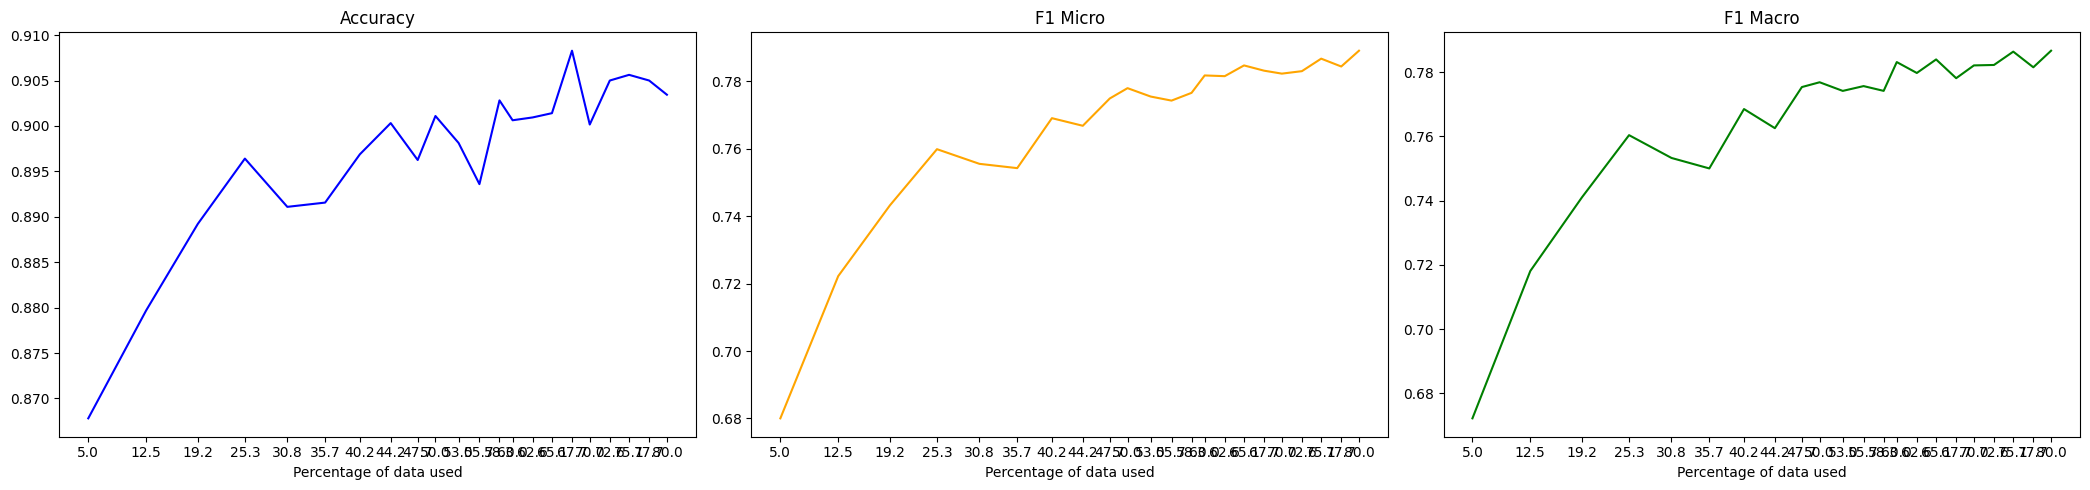

In [18]:
active_learning(seeds[0], 0)